In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
#from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
from scipy.ndimage.measurements import label


# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

In [2]:
%matplotlib inline

In [3]:
cars = []
notcars = []

In [4]:
# Read in cars and notcars


images1 = glob.glob('./vehicles/GTI_Far/*.png')
images2 = glob.glob('./vehicles/GTI_Left/*.png')
images3 = glob.glob('./vehicles/GTI_MiddleClose/*.png')
images4 = glob.glob('./vehicles/GTI_Right/*.png')

images5 = glob.glob('./vehicles/KITTI_extracted/*.png')

images = images1 + images2 + images3 + images4 + images5

'''
images11 = glob.glob('./vehicles_smallset/cars1/*.jpeg')
images21 = glob.glob('./vehicles_smallset/cars2/*.jpeg')
images31 = glob.glob('./vehicles_smallset/cars3/*.jpeg')

images+= images11 + images21 + images31


images = images1 + images2 + images3
'''
for image in images:
        cars.append(image)
       

      

In [5]:
notcar_images1 = glob.glob('./non-vehicles/GTI/*.png')
notcar_images2 = glob.glob('./non-vehicles/Extras/*.png')

'''
notcar_images1 = glob.glob('./non-vehicles_smallset/notcars1/*.jpeg')
notcar_images2 = glob.glob('./non-vehicles_smallset/notcars2/*.jpeg')
notcar_images3 = glob.glob('./non-vehicles_smallset/notcars3/*.jpeg')
notcar_images = notcar_images1 + notcar_images2 + notcar_images3
'''
notcar_images = notcar_images1 + notcar_images2
       
for image in notcar_images:
    notcars.append(image)

In [6]:
len(cars)

8792

In [7]:
len(notcars)

8968

In [8]:
vehCarNum = np.random.randint(len(cars))
nonvehCarNum = np.random.randint(len(notcars))
veh_image = mpimg.imread(cars[vehCarNum])
non_veh_image = mpimg.imread(notcars[nonvehCarNum])
plt.imsave("vehicleImage.png",veh_image)
plt.imsave("nonvehicleImage.png",non_veh_image)

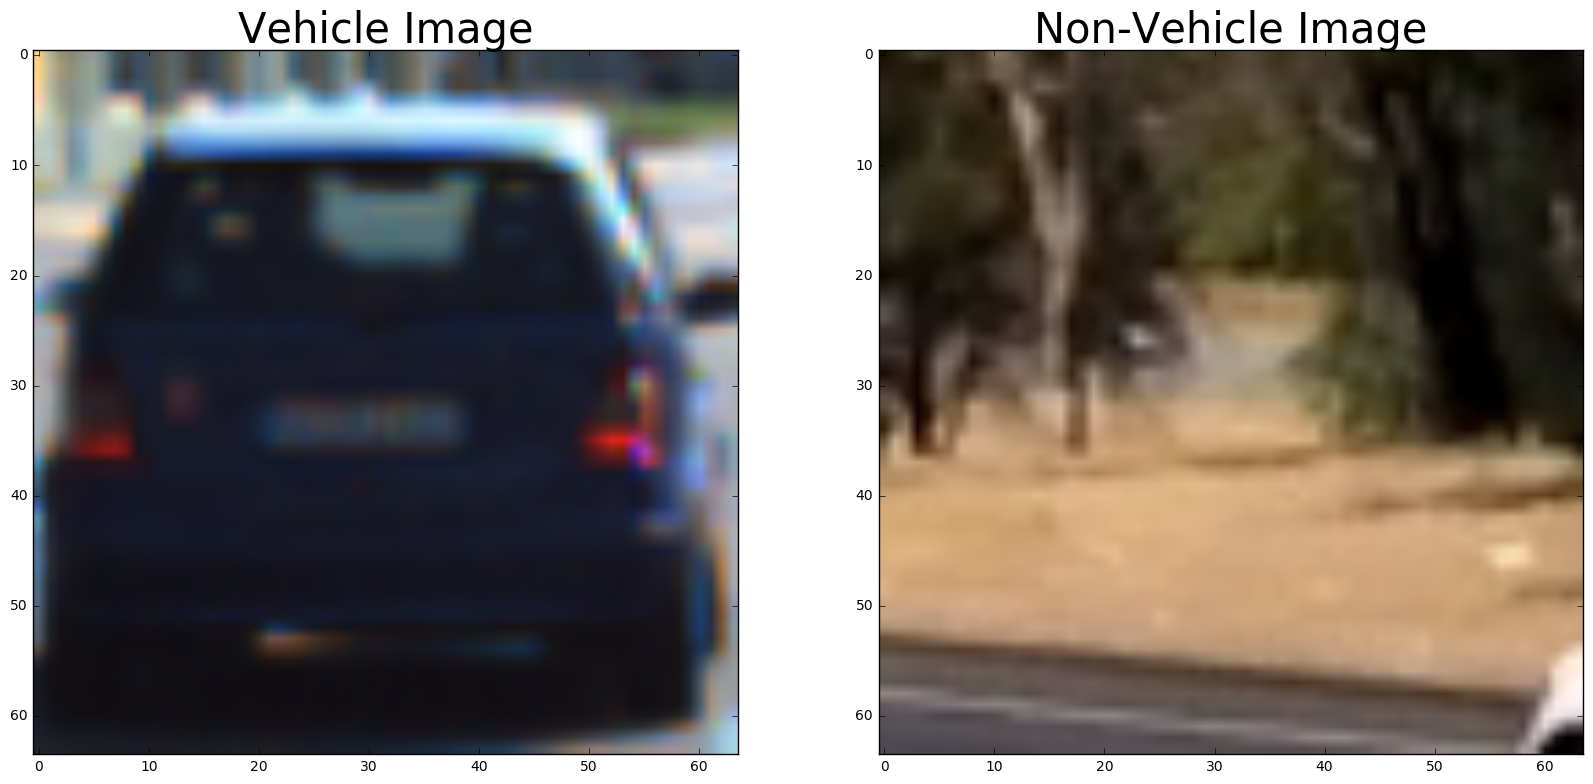

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(veh_image)
ax1.set_title('Vehicle Image', fontsize=30)
ax2.imshow(non_veh_image)
ax2.set_title('Non-Vehicle Image', fontsize=30)

In [10]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 7  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

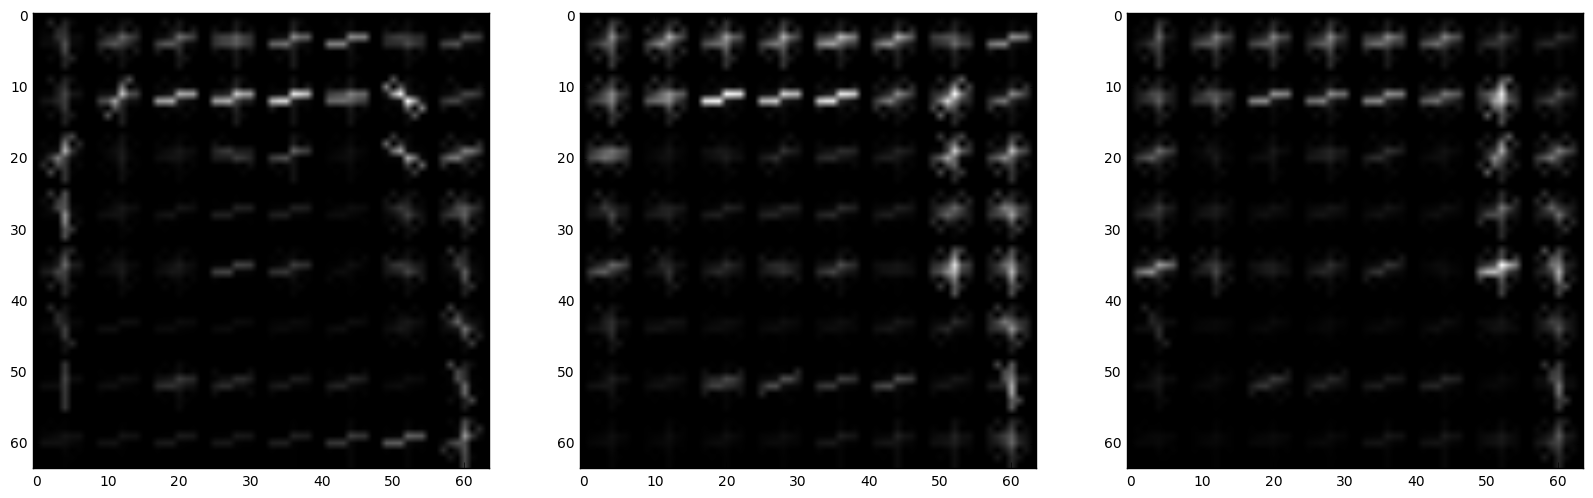

In [11]:
from skimage.feature import hog

feature_image = cv2.cvtColor(veh_image, cv2.COLOR_RGB2YUV)

features, hog_image_0 = hog(feature_image[:,:,0], orientations=orient, 
                          pixels_per_cell=(pix_per_cell, pix_per_cell),
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=True, 
                          visualise=True, feature_vector=True)
features, hog_image_1 = hog(feature_image[:,:,1], orientations=orient, 
                          pixels_per_cell=(pix_per_cell, pix_per_cell),
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=True, 
                          visualise=True, feature_vector=True)
features, hog_image_2 = hog(feature_image[:,:,2], orientations=orient, 
                          pixels_per_cell=(pix_per_cell, pix_per_cell),
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=True, 
                          visualise=True, feature_vector=True)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(hog_image_0,cmap='gray')
ax2.imshow(hog_image_1,cmap='gray')
ax3.imshow(hog_image_2,cmap='gray')

plt.imsave("hog_image_0.png",hog_image_0)
plt.imsave("hog_image_1.png",hog_image_1)
plt.imsave("hog_image_2.png",hog_image_2)

In [12]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features



In [13]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features



In [14]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [15]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [16]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [17]:
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [18]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

In [19]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [20]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [21]:
# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
rand_state = 50
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [22]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=0.1)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 7 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 9264
20.99 Seconds to train SVC...
Test Accuracy of SVC =  0.9854


In [23]:
def convert_color(img_tosearch, conv='RGB2YCrCb'):
    if conv == 'RGB2YUV':
        imgReturn = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    elif conv=='RGB2YCrCb':
        imgReturn = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    elif conv=='RGB2LUV':
        imgReturn = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
    elif conv=='RGB2HLS':
        imgReturn = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
    elif conv=='RGB2HSV':
        imgReturn = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)         
    else:
        imgReturn = img_tosearch
    return imgReturn

In [24]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [25]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [26]:
# 2 cells per block
def find_cars_2cb(img, scale):
    out_images = []
    out_maps =  []
    out_titles = []
    out_boxes = []
    #draw_img = np.copy(img)
    
    img_boxes = []
    count = 0
    #img = mpimg.imread(img)
    draw_img = np.copy(img)
    
    heatmap = np.zeros_like(img[:,:,0])
    
    img = img.astype(np.float32)/255    
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
     
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    for window in [16,24,32,48,56,64]:
        pix_per_cell = np.int32(window/8)
        
        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 



        nfeat_per_block = orient*cell_per_block**2




        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        #window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        '''
        print("img.shape = " , img.shape)        
        print("ctrans_tosearch.shape = " , ctrans_tosearch.shape)       
        print("nxblocks = " , nxblocks)
        print("nyblocks = " , nyblocks)
        print("nfeat_per_block = " , nfeat_per_block) 
        print("nblocks_per_window = " , nblocks_per_window)
        print("nxsteps = " , nxsteps)
        print("nysteps = " , nysteps) 
        '''

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                count += 1
                if ((count < nysteps / 4) & (window < 40)) or ((count >= nysteps / 4) & (window > 40)):
                    ypos = yb*cells_per_step
                    xpos = xb*cells_per_step
                    # Extract HOG for this patch
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                    #print("hog_feat1.shape = ", hog_feat1.shape)
                    #print("hog_feat2.shape = ", hog_feat2.shape)
                    #print("hog_feat3.shape = ", hog_feat3.shape)
                    #print("hog_features.shape = ", hog_features.shape)

                    xleft = xpos*pix_per_cell
                    ytop = ypos*pix_per_cell

                    # Extract the image patch
                    subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                    # Get color features
                    spatial_features = bin_spatial(subimg, size=spatial_size)
                    hist_features = color_hist(subimg, nbins=hist_bins)

                    #print("spatial_features.shape = ", spatial_features.shape)
                    #print("hist_features.shape = ", hist_features.shape)

                    #combined_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
                    # Scale features and make a prediction
                    #test_features = StandardScaler().fit_transform(combined_features)
                    test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                    #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                    #test_prediction = svc.predict(test_features)

                    dcf = svc.decision_function(test_features)
                    test_prediction = int(dcf > 0.9)

                    if test_prediction == 1:
                        xbox_left = np.int(xleft*scale)
                        ytop_draw = np.int(ytop*scale)
                        win_draw = np.int(window*scale)
                        cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                        img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                        heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1

    out_images.append(draw_img)
    
#    out_titles.append(img_src[-12:])
#    out_titles.append(img_src[-12:])
    
    #out_titles.append(img[-12:])
    #out_titles.append(img[-12:])

    
    out_images.append(heatmap)
    #out_maps.append(heatmap)
    #out_boxes.append(img_boxes)

    #return out_images, out_titles #draw_img    
    #return draw_img, heatmap #draw_img    
    return out_images, heatmap #draw_img  

In [27]:
#4 cells per block
def find_cars(img, scale):
    out_images = []
    out_maps =  []
    out_titles = []
    out_boxes = []
    #draw_img = np.copy(img)
    
    img_boxes = []
    count = 0
    #img = mpimg.imread(img)
    draw_img = np.copy(img)
    
    heatmap = np.zeros_like(img[:,:,0])
    
    img = img.astype(np.float32)/255    
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
     
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    #for window in [48]:
    #for window in [24,32,40,48,56,64,96,120,128]:
    for window in [16,24,32,48,56,64]:
        #pix_per_cell = np.int32(window/16) # with cells_per_step = 4 
        pix_per_cell = np.int32(window/8) # with cells_per_step = 2 
        #pix_per_cell = 8
    #for window in [12,24,36,48]:
        #pix_per_cell = np.int32(window/12)        
        # Define blocks and steps as above
        
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        #
        
        #nxblocks = ((ch1.shape[1] - cells_per_block)//(pix_per_cell * cells_per_block * )-1
        #nyblocks = (ch1.shape[0] // pix_per_cell)-1 


        #nfeat_per_block = orient*cell_per_block**2




        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        #window = 64
        #nblocks_per_window = (window // pix_per_cell)-1 
        
        cells_per_step = 2 # Instead of overlap, define how many cells to step
        
        nblocks_per_window = ((window // pix_per_cell)//cells_per_step) + 1 
        
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        #sub_window_size = pix_per_cell / cells_per_step + 1
        '''
        print("img.shape = " , img.shape)        
        print("ctrans_tosearch.shape = " , ctrans_tosearch.shape)       
        print("nxblocks = " , nxblocks)
        print("nyblocks = " , nyblocks)
        print("nfeat_per_block = " , nfeat_per_block) 
        print("nblocks_per_window = " , nblocks_per_window)
        print("nxsteps = " , nxsteps)
        print("nysteps = " , nysteps) 
        '''

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        #print("hog2.shape = ", hog2.shape)
        #print("hog3.shape = ", hog3.shape)
                
        #hog1 = get_hog_features(ch1, orient, pix_per_cell, cells_per_step, feature_vec=False)
        #hog2 = get_hog_features(ch2, orient, pix_per_cell, cells_per_step, feature_vec=False)
        #hog3 = get_hog_features(ch3, orient, pix_per_cell, cells_per_step, feature_vec=False)        

        for xb in range(nxsteps):
            for yb in range(nysteps):
                count += 1
                if ((count < nysteps / 4) & (window < 40)) or ((count >= nysteps / 4) & (window > 40)):
                    ypos = yb*cells_per_step
                    xpos = xb*cells_per_step
                    # Extract HOG for this patch
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                    #print("hog_feat1.shape = ", hog_feat1.shape)
                    #print("hog_feat2.shape = ", hog_feat2.shape)
                    #print("hog_feat3.shape = ", hog_feat3.shape)
                    #print("hog_features.shape = ", hog_features.shape)

                    xleft = xpos*pix_per_cell
                    ytop = ypos*pix_per_cell

                    # Extract the image patch
                    subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                    # Get color features
                    spatial_features = bin_spatial(subimg, size=spatial_size)
                    hist_features = color_hist(subimg, nbins=hist_bins)

                    #print("spatial_features.shape = ", spatial_features.shape)
                    #print("hist_features.shape = ", hist_features.shape)

                    #combined_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
                    # Scale features and make a prediction
                    #test_features = StandardScaler().fit_transform(combined_features)
                    test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
   
                    #test_prediction = svc.predict(test_features)

                    dcf = svc.decision_function(test_features)
                    test_prediction = int(dcf > 0.9)

                    if test_prediction == 1:
                        xbox_left = np.int(xleft*scale)
                        ytop_draw = np.int(ytop*scale)
                        win_draw = np.int(window*scale)
                        cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                        img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                        heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1

    out_images.append(draw_img)
    
#    out_titles.append(img_src[-12:])
#    out_titles.append(img_src[-12:])
    
    #out_titles.append(img[-12:])
    #out_titles.append(img[-12:])

    
    out_images.append(heatmap)
    #out_maps.append(heatmap)
    #out_boxes.append(img_boxes)

    #return out_images, out_titles #draw_img    
    #return draw_img, heatmap #draw_img    
    return out_images, heatmap #draw_img    

In [28]:
testImages = glob.glob('./test_images/t*.jpg')

images = []
for image in testImages:
    images.append(image)
print("number of images = ", len(images))

number of images =  6


In [29]:
ystart = 384#400
ystop = 656#704
scale = 1.5 #1.75 #2 #3 #0.75
thresholdValue = 4

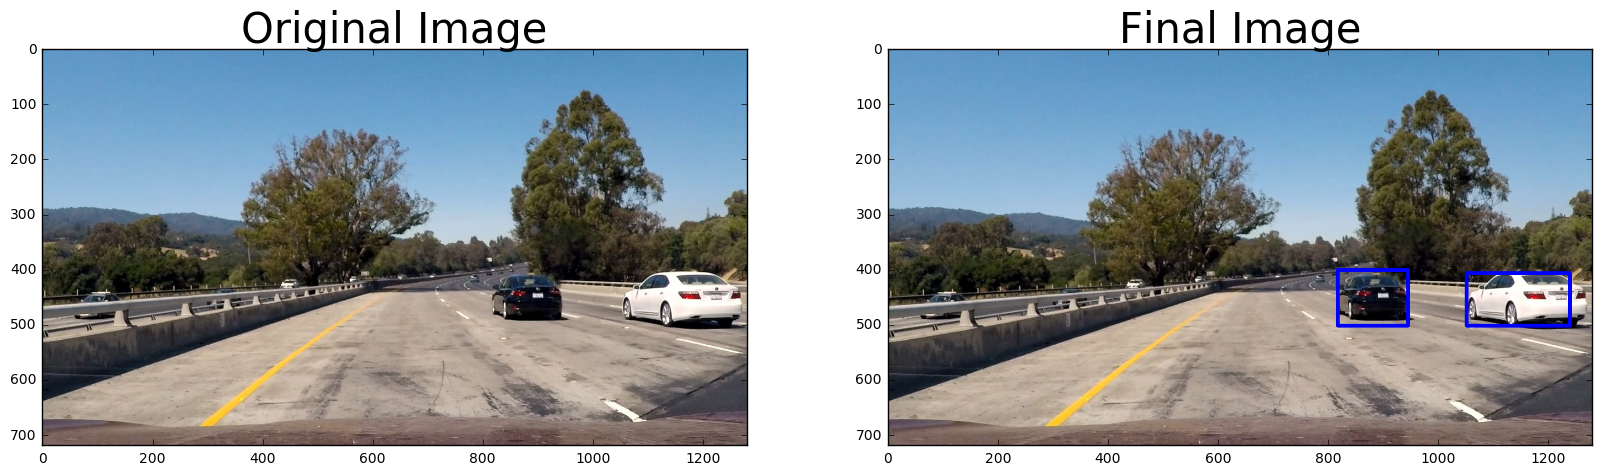

In [30]:
img = mpimg.imread(images[0])
out_img, heat_map = find_cars(img, scale)

hm_Copy = np.copy(heat_map)
hm_Copy = apply_threshold(hm_Copy, thresholdValue)


labels = label(hm_Copy)


draw_img = draw_labeled_bboxes(np.copy(img), labels)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(draw_img)
ax2.set_title('Final Image', fontsize=30)

plt.imsave("./test_images/boxes_Test1.jpg",draw_img)
plt.imsave("./test_images/heatmap_bt_Test1.jpg",heat_map) # before threshold
plt.imsave("./test_images/heatmap_at_Test1.jpg",hm_Copy) # after threshold


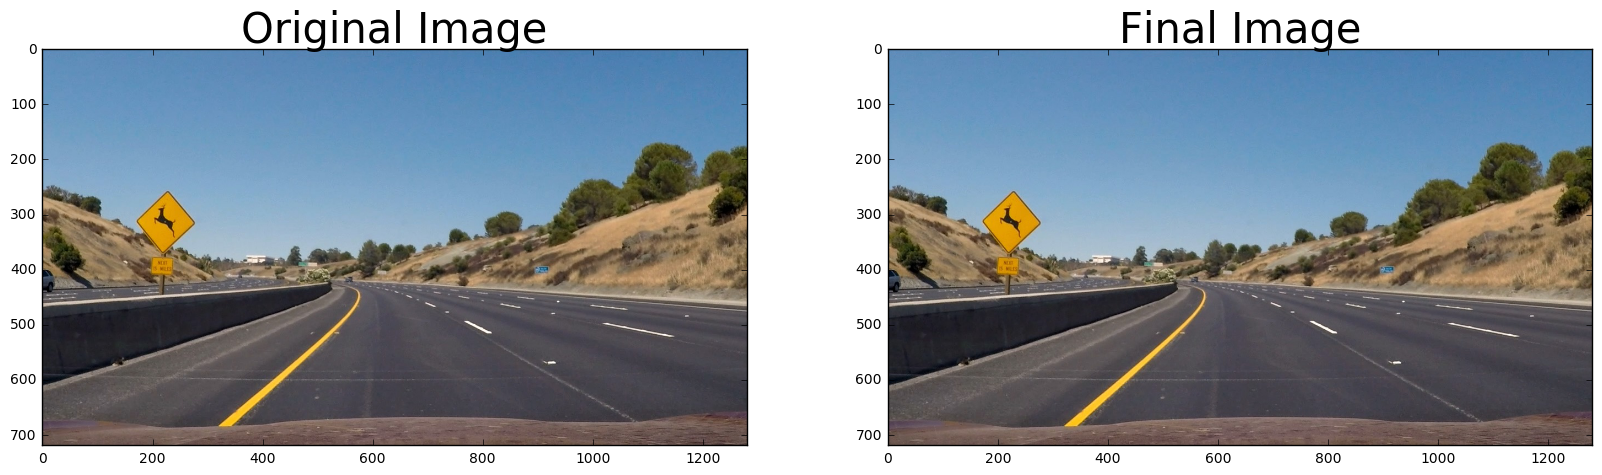

In [31]:
img = mpimg.imread(images[1])
#scale = 2
out_img, heat_map = find_cars(img, scale)
hm_Copy = np.copy(heat_map)
hm_Copy = apply_threshold(hm_Copy,thresholdValue)

labels = label(hm_Copy)

draw_img = draw_labeled_bboxes(np.copy(img), labels)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(draw_img)
ax2.set_title('Final Image', fontsize=30)
plt.imsave("./test_images/boxes_Test2.jpg",draw_img)
plt.imsave("./test_images/heatmap_bt_Test2.jpg",heat_map) # before threshold
plt.imsave("./test_images/heatmap_at_Test2.jpg",hm_Copy) # after threshold

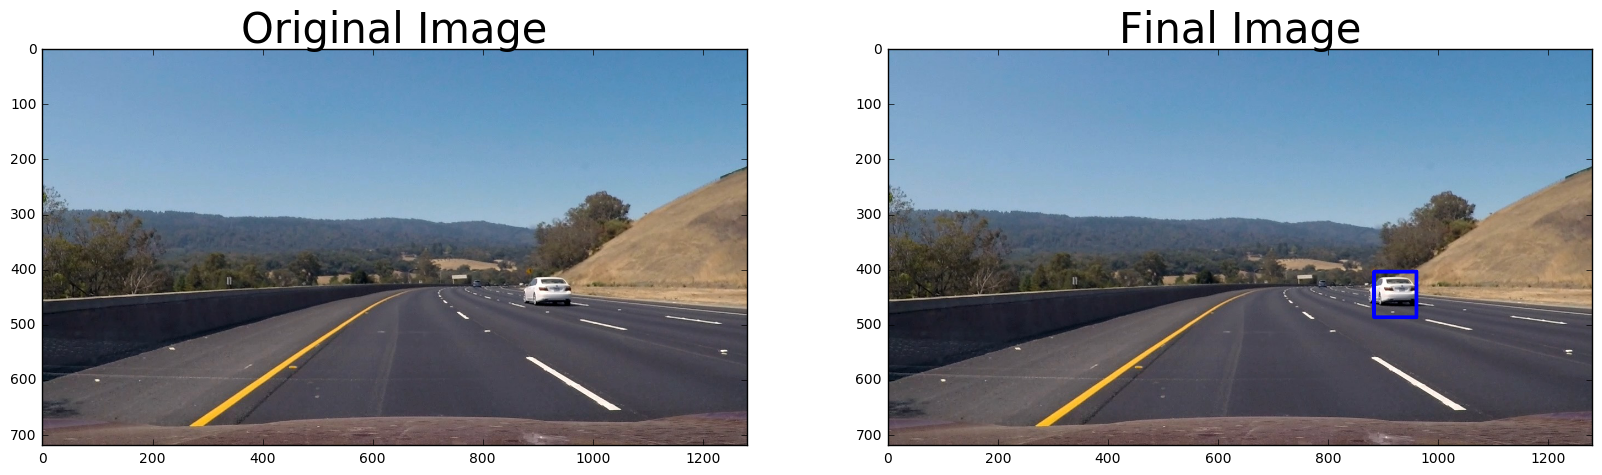

In [32]:
img = mpimg.imread(images[2])
#scale = 2
out_img, heat_map = find_cars(img, scale)
hm_Copy = np.copy(heat_map)
hm_Copy = apply_threshold(hm_Copy, thresholdValue)

labels = label(hm_Copy)

draw_img = draw_labeled_bboxes(np.copy(img), labels)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(draw_img)
ax2.set_title('Final Image', fontsize=30)
plt.imsave("./test_images/boxes_Test3.jpg",draw_img)
plt.imsave("./test_images/heatmap_bt_Test3.jpg",heat_map) # before threshold
plt.imsave("./test_images/heatmap_at_Test3.jpg",hm_Copy) # after threshold

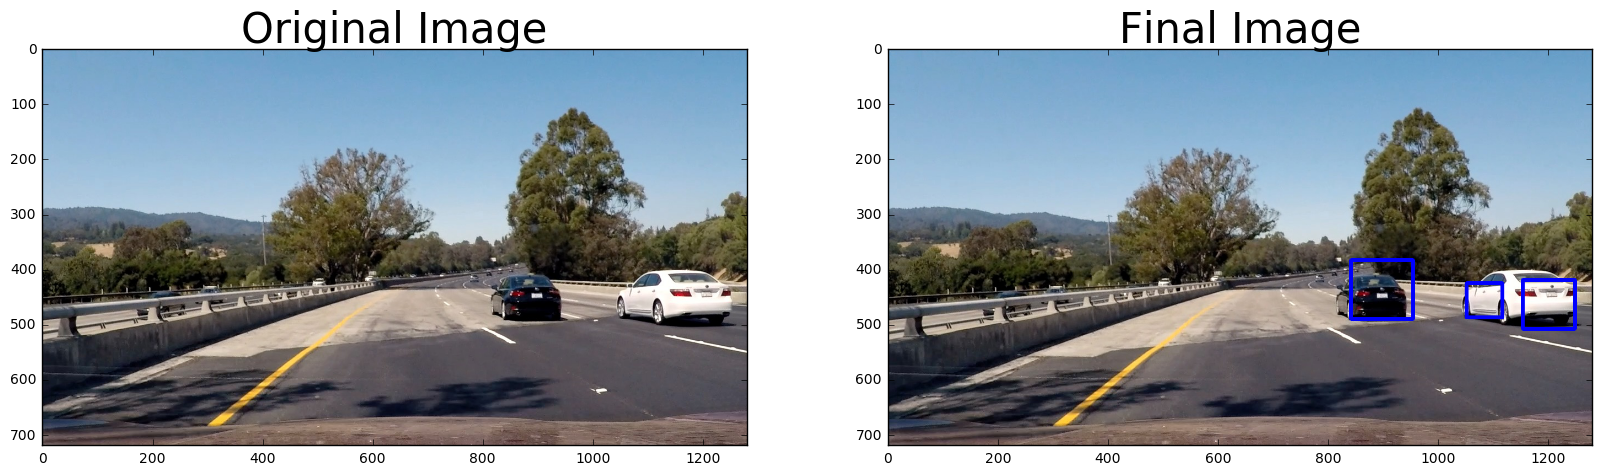

In [33]:
img = mpimg.imread(images[3])
#scale = 2
out_img, heat_map = find_cars(img, scale)
hm_Copy = np.copy(heat_map)
#hm_Copy = apply_threshold(hm_Copy, thresholdValue)
hm_Copy = apply_threshold(hm_Copy, thresholdValue)

labels = label(hm_Copy)

draw_img = draw_labeled_bboxes(np.copy(img), labels)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(draw_img)
ax2.set_title('Final Image', fontsize=30)
plt.imsave("./test_images/boxes_Test4.jpg",draw_img)
plt.imsave("./test_images/heatmap_bt_Test4.jpg",heat_map) # before threshold
plt.imsave("./test_images/heatmap_at_Test4.jpg",hm_Copy) # after threshold

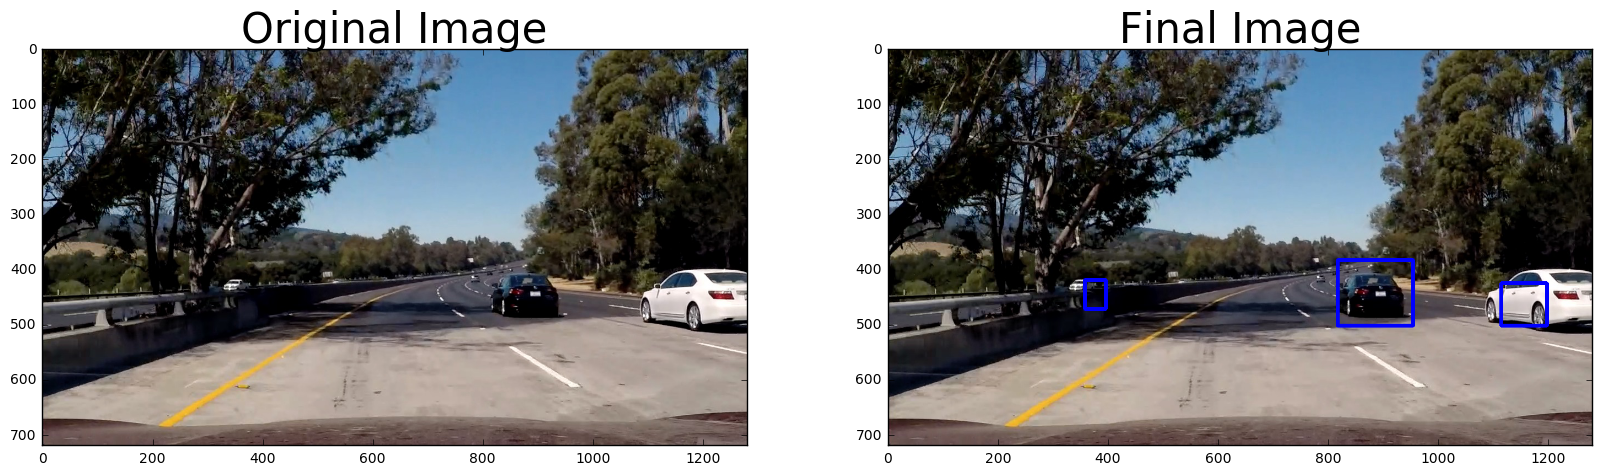

In [34]:

img = mpimg.imread(images[4])
#scale = 2
out_img, heat_map = find_cars(img, scale)
hm_Copy = np.copy(heat_map)
hm_Copy = apply_threshold(hm_Copy, thresholdValue)

labels = label(hm_Copy)

draw_img = draw_labeled_bboxes(np.copy(img), labels)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(draw_img)
ax2.set_title('Final Image', fontsize=30)
plt.imsave("./test_images/boxes_Test5.jpg",draw_img)
plt.imsave("./test_images/heatmap_bt_Test5.jpg",heat_map) # before threshold
plt.imsave("./test_images/heatmap_at_Test5.jpg",hm_Copy) # after threshold

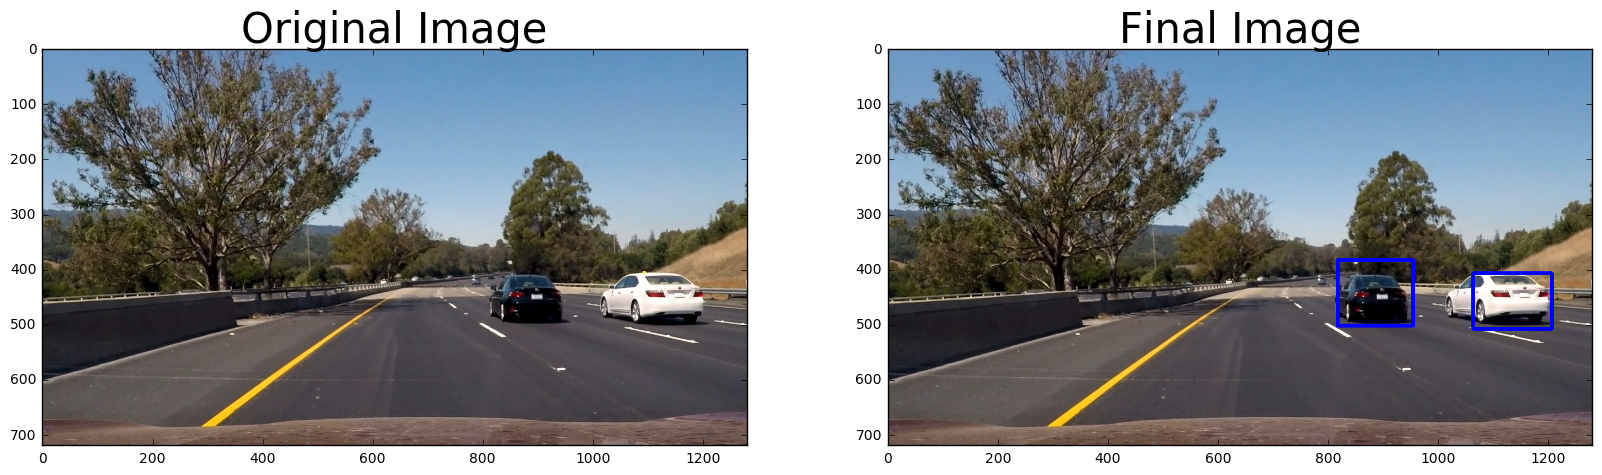

In [35]:
img = mpimg.imread(images[5])
#scale = 2
out_img, heat_map = find_cars(img, scale)
hm_Copy = np.copy(heat_map)
hm_Copy = apply_threshold(hm_Copy, thresholdValue)

labels = label(hm_Copy)

draw_img = draw_labeled_bboxes(np.copy(img), labels)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(draw_img)
ax2.set_title('Final Image', fontsize=30)
plt.imsave("./test_images/boxes_Test6.jpg",draw_img)
plt.imsave("./test_images/heatmap_bt_Test6.jpg",heat_map) # before threshold
plt.imsave("./test_images/heatmap_at_Test6.jpg",hm_Copy) # after threshold

In [36]:
def process_image(img):
    
    out_img, heat_map = find_cars(img, scale)
    
    heat_map = apply_threshold(heat_map, 3)
    
    labels = label(heat_map)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [37]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
movie_output = 'movie.mp4'
clip1 = VideoFileClip("test_video.mp4")#challenge_video
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(movie_output, audio=False)  


[MoviePy] >>>> Building video movie.mp4
[MoviePy] Writing video movie.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [02:20<00:03,  3.69s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie.mp4 



In [39]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
movie_output = 'movie_project_video_copy32.mp4'
#movie_output = 'movie_challenge.mp4'
#movie_output = 'movie_harder_challenge.mp4'
#clip1 = VideoFileClip("test_video.mp4")#challenge_video
clip1 = VideoFileClip("project_video.mp4")#challenge_video
#clip1 = VideoFileClip("challenge_video.mp4")#challenge_video # harder_challenge_video
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(movie_output, audio=False) 

[MoviePy] >>>> Building video movie_project_video_copy32.mp4
[MoviePy] Writing video movie_project_video_copy32.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:11:26<00:03,  3.38s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: movie_project_video_copy32.mp4 

